# Predicting Energy Consumption with XGBoost

Regression analysis can be used to model the relationship between a dependent variable and one or more independent variables. 
- In the context of time series analysis, regression can be used to model the relationship between a time series variable and one or more predictor variables.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

Lets read and show the data

In [10]:
df = pd.read_csv('data/PJME_hourly.csv')
df = df.sort_values('Datetime')
df = df.set_index("Datetime")
df.head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


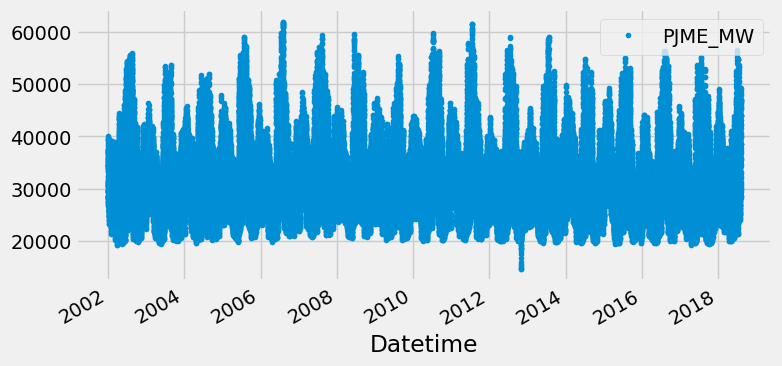

In [11]:
df.index = pd.to_datetime(df.index)
df.plot(figsize=(8,4), style='.')
plt.show()

## Train / Test Split

Unlike traditional train/test splitting, where the data is randomly divided into training and testing sets, in time series analysis, the data is split in chronological order, such that the training set includes data from earlier time periods and the testing set includes data from later time periods.

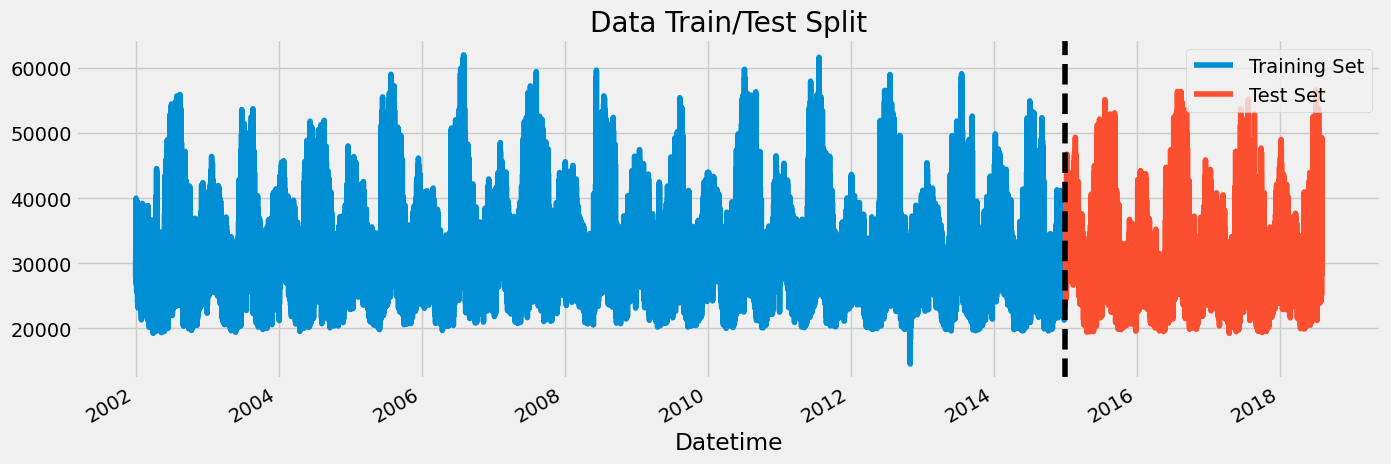

In [12]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

What does a single week of data looks like?

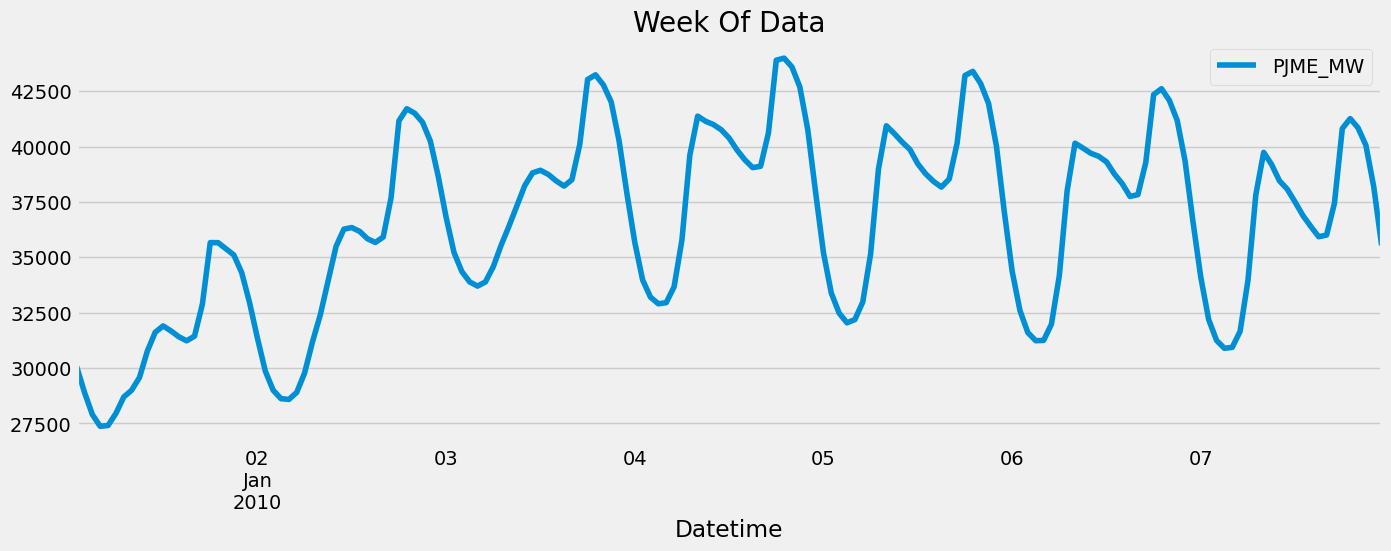

In [13]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

Now, lets create some features that are relevant to the forecasting, and that are related to the date

In [14]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1


### Visualize our Feature / Target Relationship

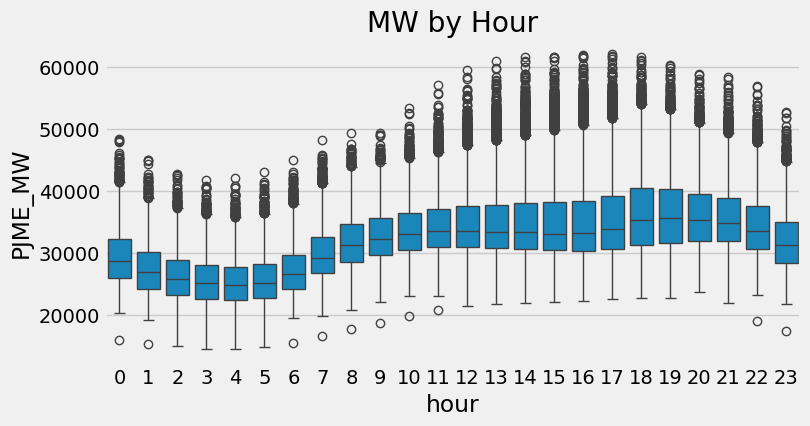

In [15]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

/tmp/ipykernel_29392/2202713226.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')


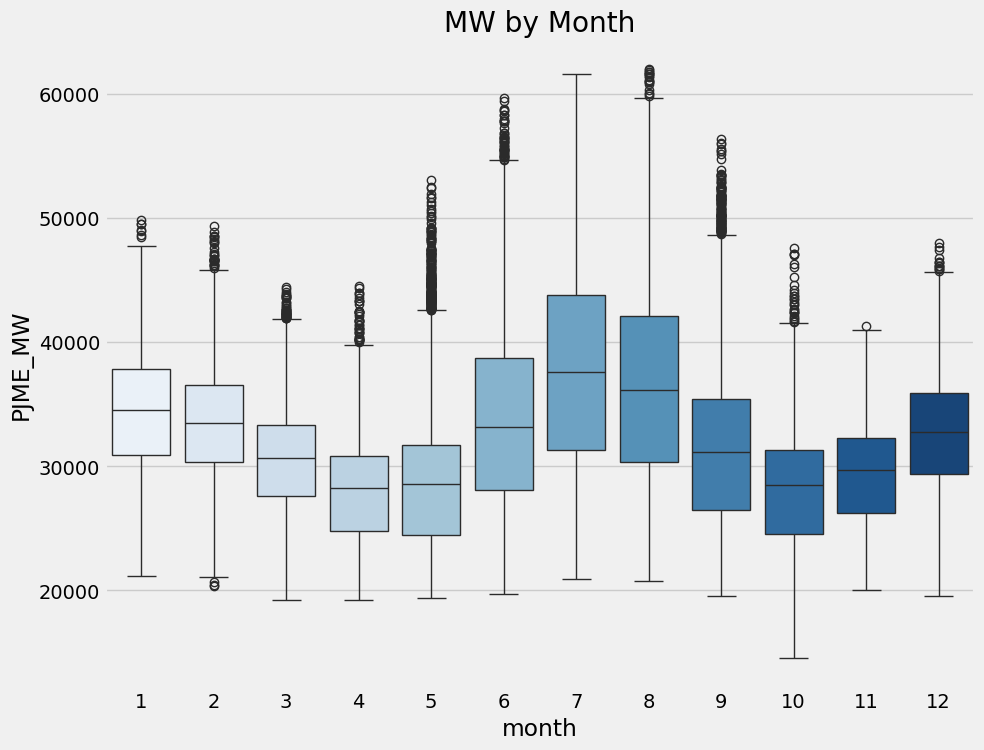

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

## Create our Model

In [17]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

We will use XGB regressor, a very powerfull classifier based on decision trees and boosting

In [18]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],        
        verbose=True)

[0]	validation_0-rmse:5179.23300	validation_1-rmse:5359.30943
[1]	validation_0-rmse:4375.01962	validation_1-rmse:4687.00132
[2]	validation_0-rmse:3874.17400	validation_1-rmse:4279.28898
[3]	validation_0-rmse:3572.89245	validation_1-rmse:4082.60841
[4]	validation_0-rmse:3372.17780	validation_1-rmse:3952.54672
[5]	validation_0-rmse:3247.62891	validation_1-rmse:3881.05746
[6]	validation_0-rmse:3162.64310	validation_1-rmse:3856.13245
[7]	validation_0-rmse:3073.82520	validation_1-rmse:3790.13994
[8]	validation_0-rmse:3021.60497	validation_1-rmse:3790.80157
[9]	validation_0-rmse:2967.30458	validation_1-rmse:3762.76936
[10]	validation_0-rmse:2888.42820	validation_1-rmse:3765.37637
[11]	validation_0-rmse:2870.15625	validation_1-rmse:3759.06623
[12]	validation_0-rmse:2813.33663	validation_1-rmse:3779.46019
[13]	validation_0-rmse:2779.04333	validation_1-rmse:3817.51231
[14]	validation_0-rmse:2760.93139	validation_1-rmse:3808.04851
[15]	validation_0-rmse:2739.22479	validation_1-rmse:3798.04910
[1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

You can see that the error in the validation set starts to increase, so we have overfitted the model.

Lets try with a small learning rate to move slower ..

In [20]:
reg = xgb.XGBRegressor(n_estimators=1000, 
                       early_stopping_rounds=50, learning_rate=0.001)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],        
        verbose=100)

[0]	validation_0-rmse:6447.78573	validation_1-rmse:6517.54145
[100]	validation_0-rmse:6026.49339	validation_1-rmse:6131.08053
[200]	validation_0-rmse:5654.75124	validation_1-rmse:5796.65490
[300]	validation_0-rmse:5326.88030	validation_1-rmse:5505.59274
[400]	validation_0-rmse:5039.56899	validation_1-rmse:5253.21086
[500]	validation_0-rmse:4788.58887	validation_1-rmse:5034.74880
[600]	validation_0-rmse:4565.97498	validation_1-rmse:4847.76655
[700]	validation_0-rmse:4372.19812	validation_1-rmse:4687.11295
[800]	validation_0-rmse:4202.53312	validation_1-rmse:4547.57144
[900]	validation_0-rmse:4055.65261	validation_1-rmse:4427.00726
[999]	validation_0-rmse:3929.32983	validation_1-rmse:4325.35302


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Lets move now a little faster in order to find a best solution

In [21]:
reg = xgb.XGBRegressor(n_estimators=1000, 
                       early_stopping_rounds=50, learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],        
        verbose=100)

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.83677
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.99037
[417]	validation_0-rmse:2801.66222	validation_1-rmse:3749.30897


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Feature Importance

In [22]:
reg.feature_importances_

array([0.11509794, 0.45519835, 0.16269566, 0.02801861, 0.21561086,
       0.02337854], dtype=float32)

Values are meaningless, so lets improve the visualization by creating a new dataframe

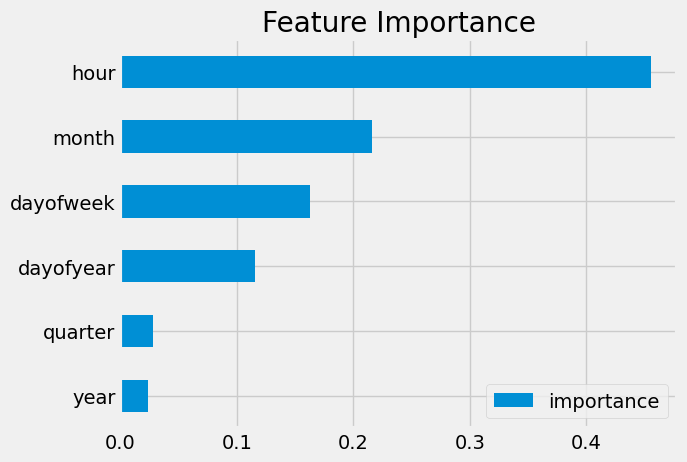

In [23]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

Lets see the correlations between features ...

<Axes: >

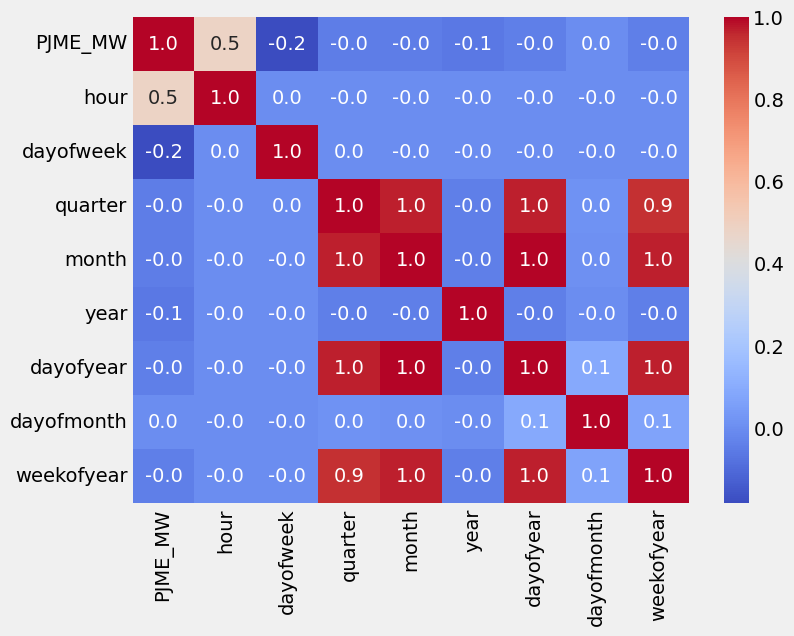

In [24]:
correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.1f')

## Forecast on Test

In [25]:
y_pred = reg.predict(X_test)
y_pred

array([32393.352, 30876.115, 30472.875, ..., 39968.492, 36870.242,
       32298.006], dtype=float32)

For a better visualization, lets add the predicted values to the original dataset

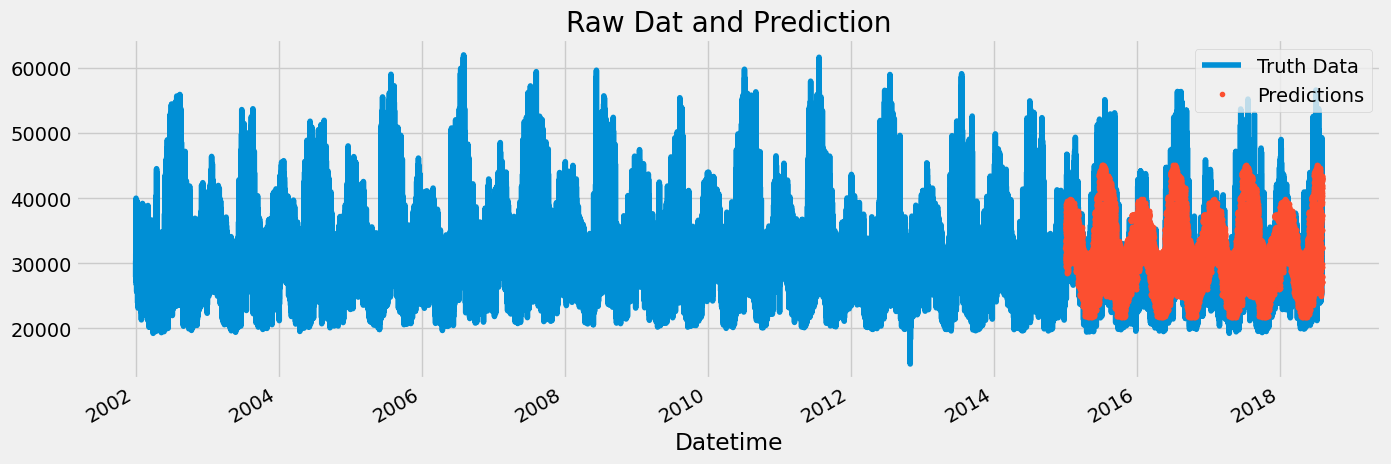

In [26]:
test['prediction'] = y_pred
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

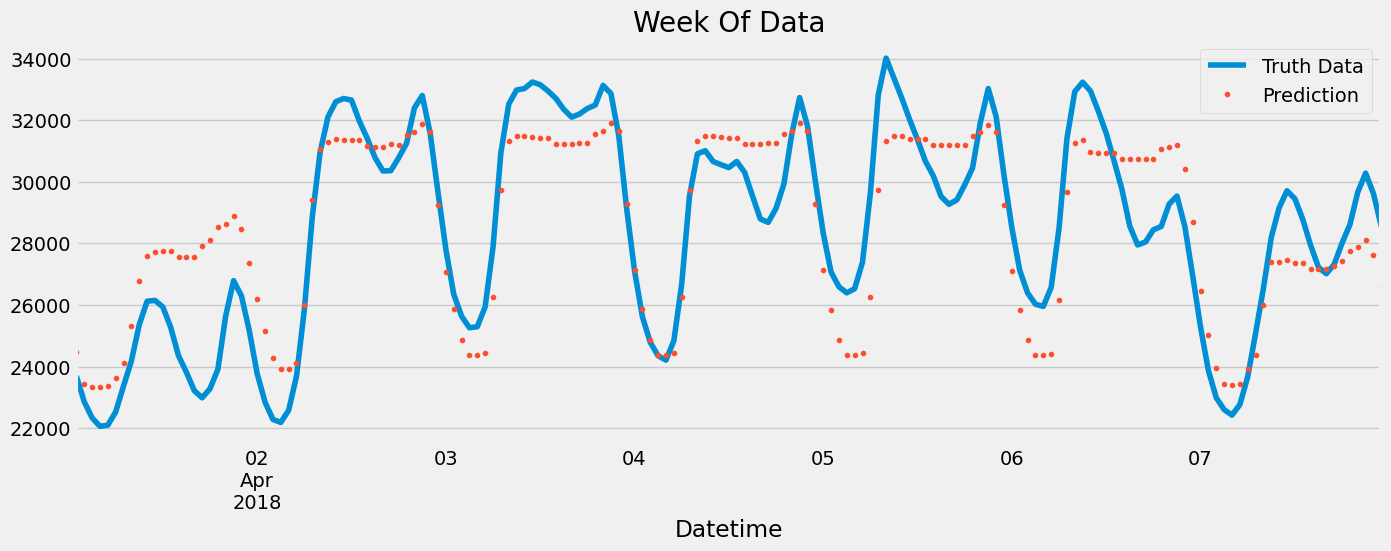

In [27]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

Results are not as good as they can be, but the regressor have managed to capture the seasonality.

## Score (RMSE)

In [28]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3741.16


Look at the worst predicted days ... where they hollidays?

In [29]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    13829.866211
2016-08-14    13577.304362
2016-09-10    11235.855143
2016-09-09    11032.220215
2016-08-12    10667.820312
2018-01-06    10407.698161
2015-02-20    10143.611491
2017-05-19     9495.122640
2016-07-04     9440.610596
2016-07-23     9362.332682
Name: error, dtype: float64

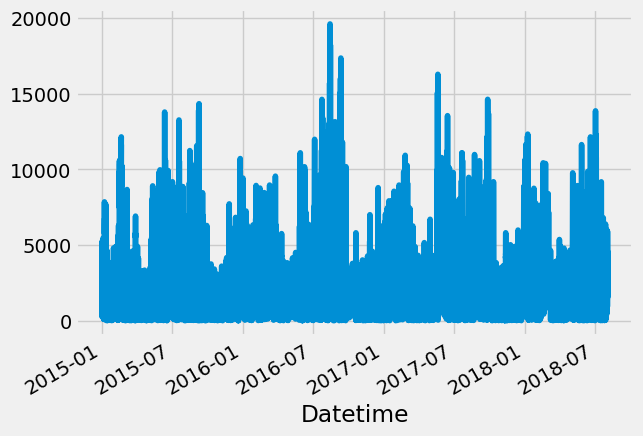

In [30]:
test.error.plot()
ax.set_title('Errors per day')
plt.show()

Lets zoom the errors in a year

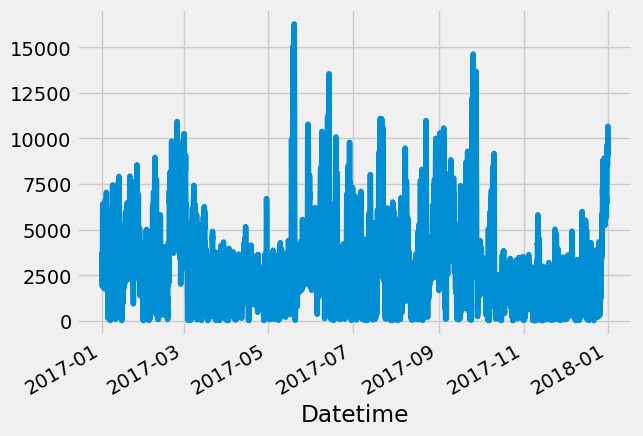

In [31]:
test.error.loc[(test.index > '01-01-2017') & (test.index < '01-01-2018')].plot()
ax.set_title('Errors per day in a year')
plt.show()

And zoom in a week

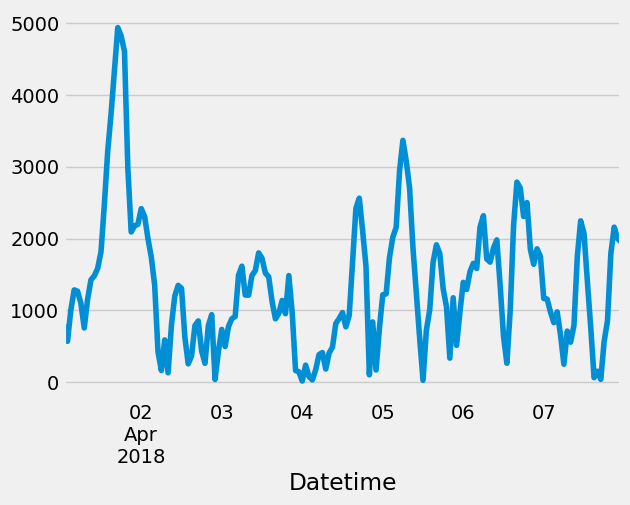

In [32]:
test.error.loc[(test.index > '04-01-2018') & (test.index < '04-08-2018')].plot()
ax.set_title('Errors per day in a week')
plt.show()

Plenty of room to improve:
- More robust cross validation
- Add more features (weather forecast, holidays)

## Outlier Analysis and removal

<Axes: ylabel='Frequency'>

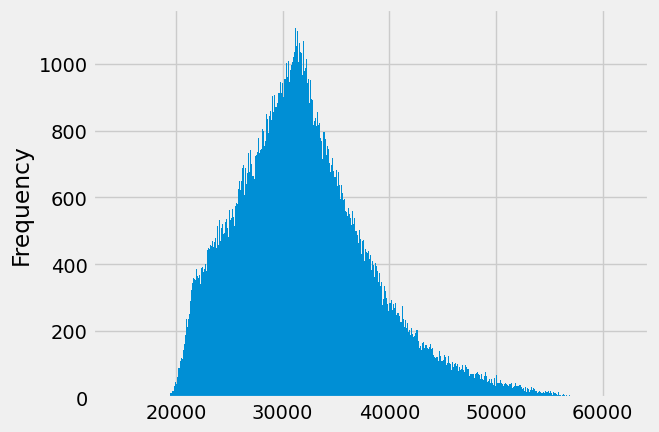

In [33]:
df['PJME_MW'].plot(kind='hist', bins=500)

Lets first consider those points with largest values

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

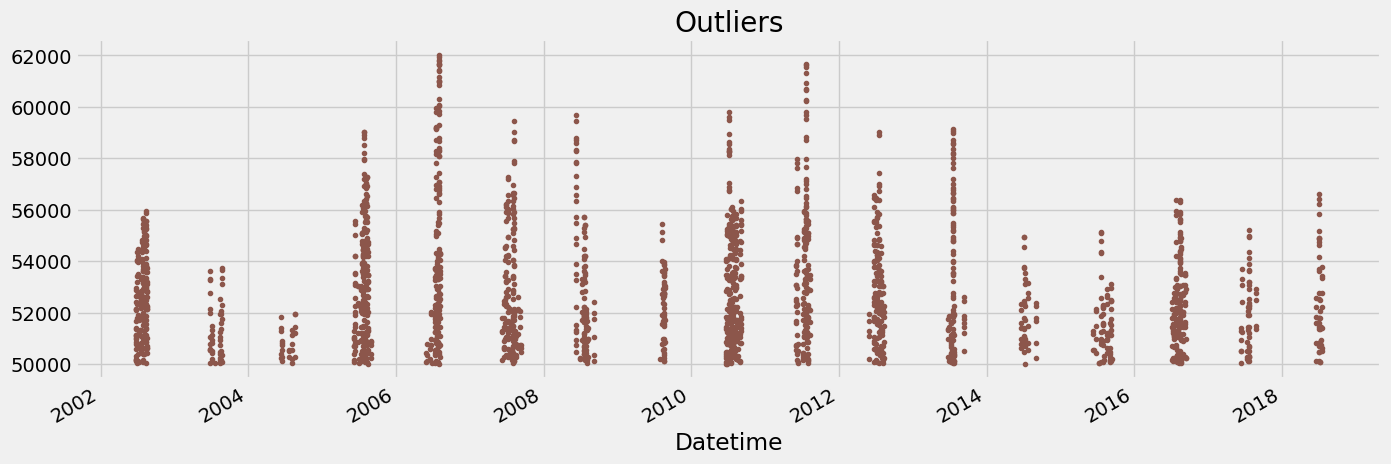

In [34]:
df.query('PJME_MW > 50_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

They are consistent with the times of the year where the demand is higher.

Now, lets see the days with lowest consumption

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

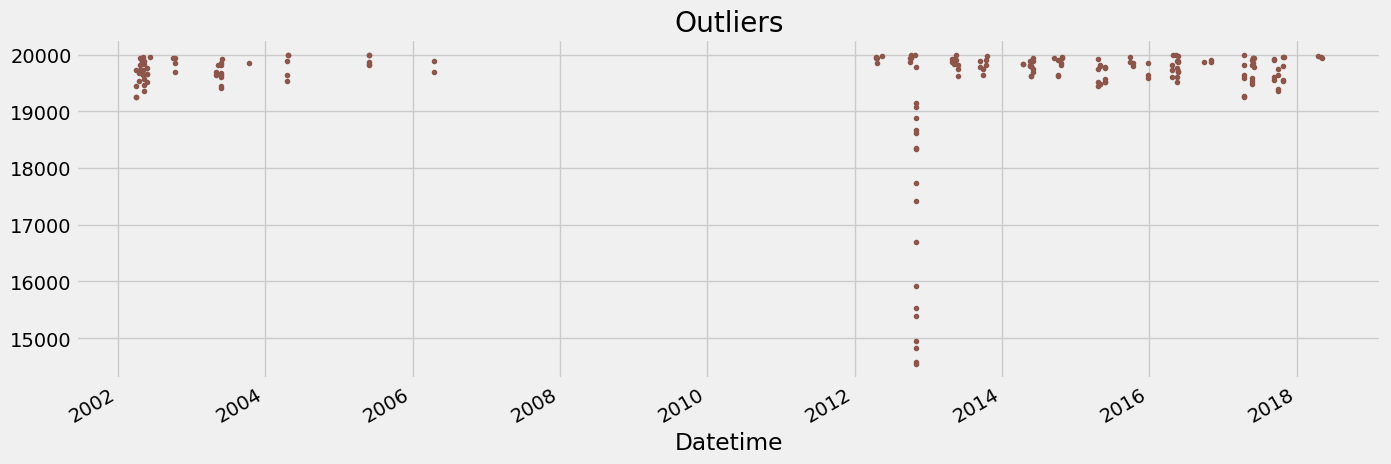

In [35]:
df.query('PJME_MW < 20_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

Most of the points are consistent, but some of them have a nasty behavior. 
- Maybe they are real values, but not usefull for predicting in the future.

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

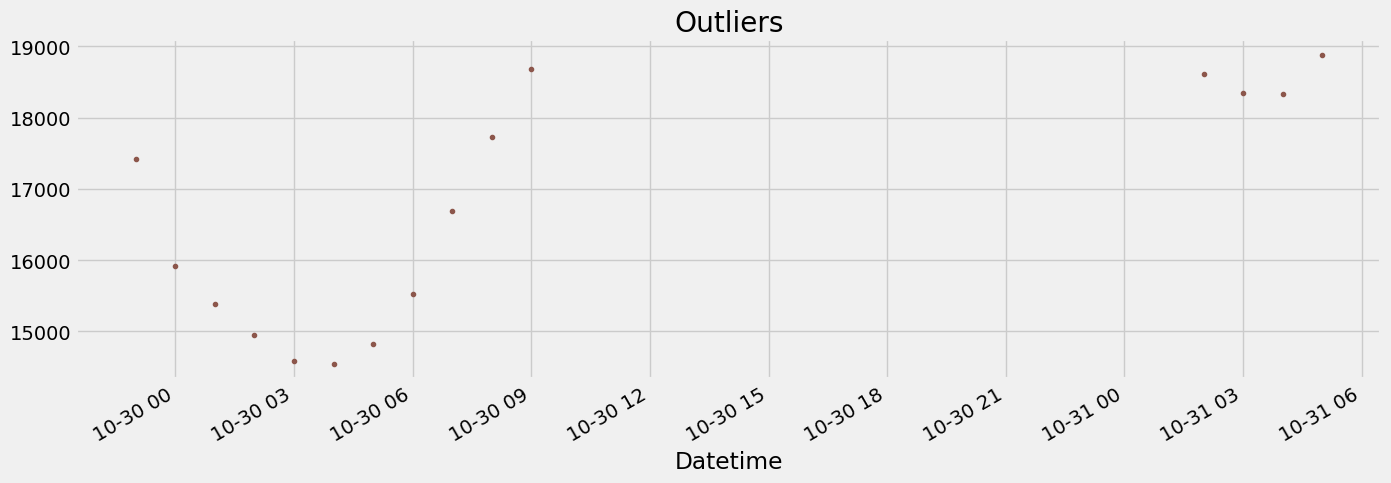

In [36]:
df.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [37]:
df = df.query('PJME_MW > 19_000').copy()

## Walk-forward validation (Cross Validation for Time Series)

The traditional k-fold cross-validation approach is not suitable for time series data because it assumes that the data is independently and identically distributed, which is not true for time series data. 
- Instead, we need to use a modified form of cross-validation that takes into account the temporal dependencies in the data.

In [38]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

In [39]:
tss.split(df)

<generator object TimeSeriesSplit._split at 0x7fa711eacf90>

It is generator ...

In [40]:
iterator = iter(tss.split(df))
train_range, test_range = next(iterator)
print(train_range)
print(test_range)

[     0      1      2 ... 101530 101531 101532]
[101557 101558 101559 ... 110314 110315 110316]


In [41]:
train_range, test_range = next(iterator)
print(train_range)
print(test_range)

[     0      1      2 ... 110290 110291 110292]
[110317 110318 110319 ... 119074 119075 119076]


In [42]:
train_range, test_range = next(iterator)
print(train_range)
print(test_range)

[     0      1      2 ... 119050 119051 119052]
[119077 119078 119079 ... 127834 127835 127836]


It is clearer in a graphical representation

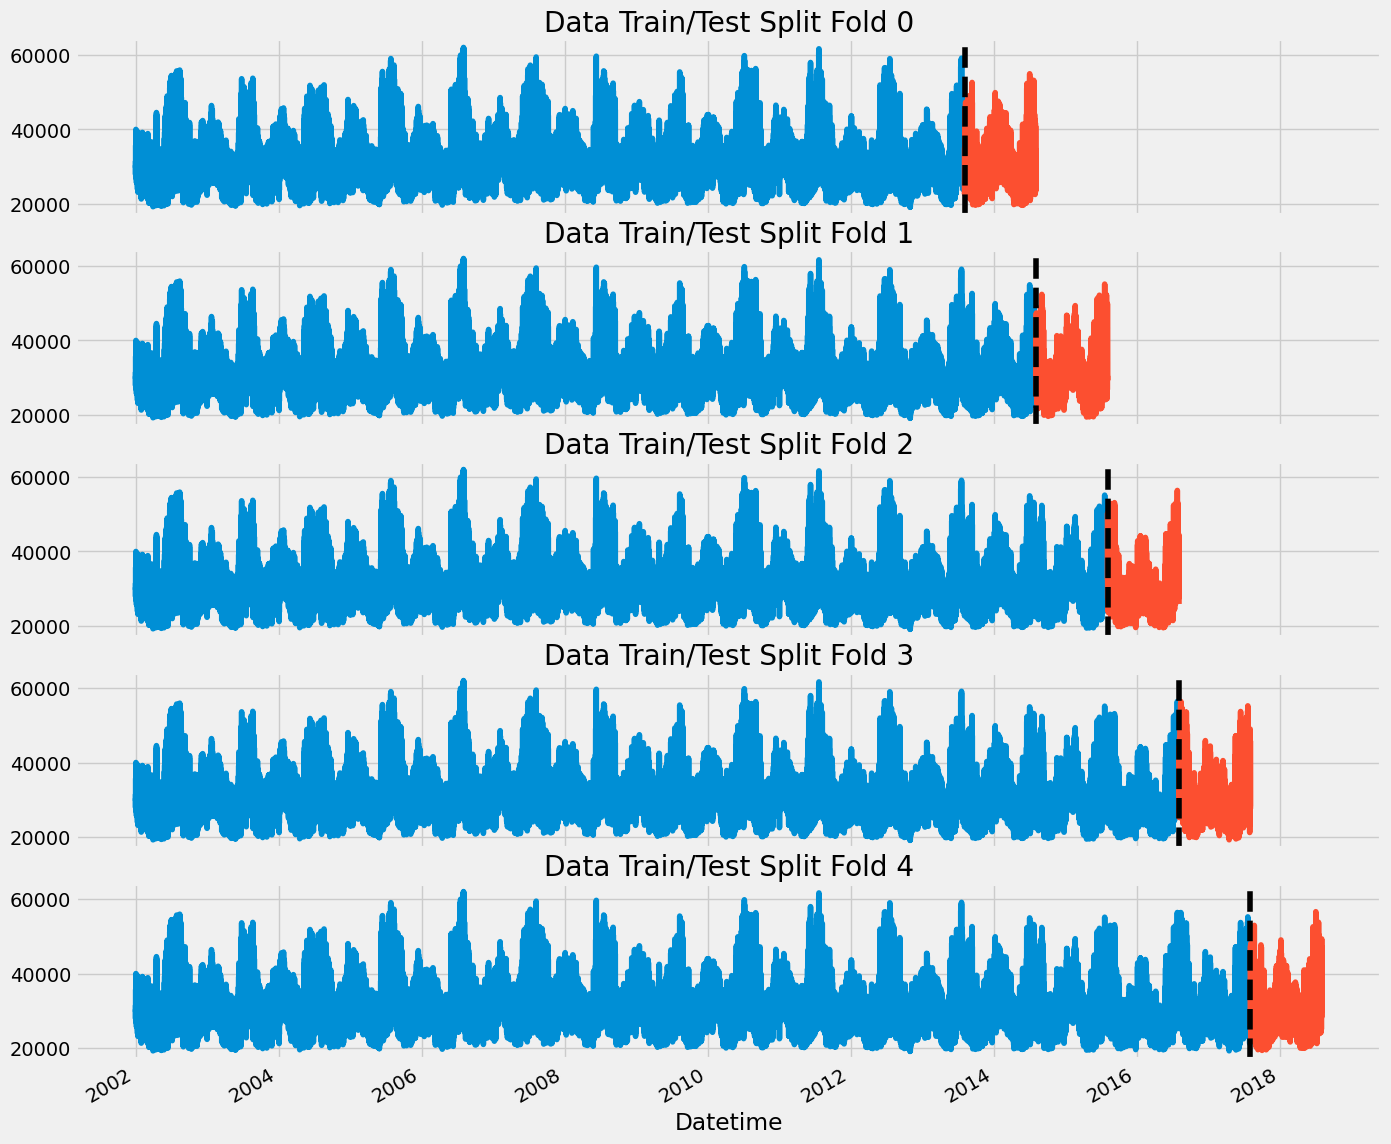

In [43]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

## Forecasting Horizon

The forecast horizon is the length of time into the future for which forecasts are to be prepared. 
- These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).

## Lag Features

In time series analysis, lag features are variables that represent past values of the time series variable being analyzed. 
- Lag features are used to capture the autocorrelation or dependency of the time series variable on its past values.

In [ ]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

add_lags(df)

In [ ]:
df[df.index > '2010-01-01'][['PJME_MW','lag1', 'lag2', 'lag3']].head()

,PJME_MW,lag1,lag2,lag3
Datetime,,,,
2010-01-01 01:00:00,30075.0,31630.0,35291.0,26152.0
2010-01-01 02:00:00,28907.0,30500.0,34450.0,25030.0
2010-01-01 03:00:00,27906.0,29880.0,34217.0,24449.0
2010-01-01 04:00:00,27373.0,29682.0,34318.0,24230.0
2010-01-01 05:00:00,27411.0,30072.0,35032.0,24701.0


## Using Lags and Cross Validation together

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[12:26:12] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32731.17798	validation_1-rmse:31989.02727
[100]	validation_0-rmse:12532.23442	validation_1-rmse:11933.13585
[200]	validation_0-rmse:5743.10258	validation_1-rmse:5353.66496
[300]	validation_0-rmse:3870.53529	validation_1-rmse:3862.46452
[400]	validation_0-rmse:3433.35539	validation_1-rmse:3707.72058
[454]	validation_0-rmse:3355.16599	validation_1-rmse:3710.02246
[12:26:20] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32671.76575	validation_1-rmse:32156.47517
[100]	validation_0-rmse:12513.30622	validation_1-rmse:12245.88651
[200]	validation_0-rmse:5755.24052	validation_1-rmse:5678.52353
[300]	validation_0-rmse:3903.74943	validation_1-rmse:3937.60443
[400]	validation_0-rmse:3476.16473	validation_1-rmse:3596.56727
[500]	validation_0-rmse:3354.72346	validation_1-rmse:3

In [ ]:
scores

[3705.884409388113,
 3438.6289810109456,
 3457.061149100903,
 4089.0688974803784,
 3992.968000557776]

In [ ]:
np.mean(scores)

3736.722287507623

Lets see the importance of the lag features for the last regressor

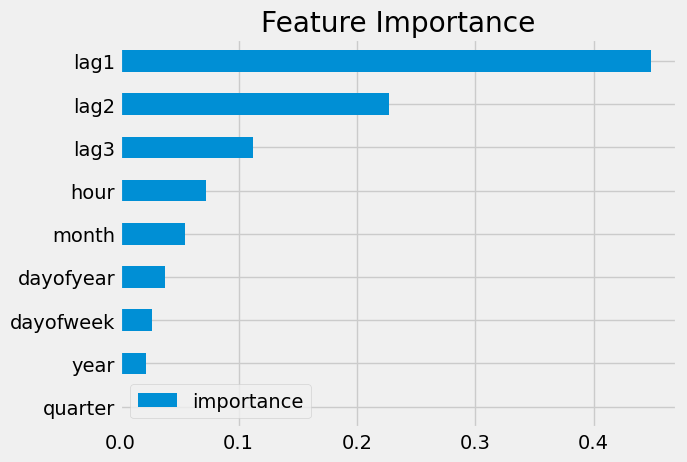

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

<Axes: xlabel='Datetime'>

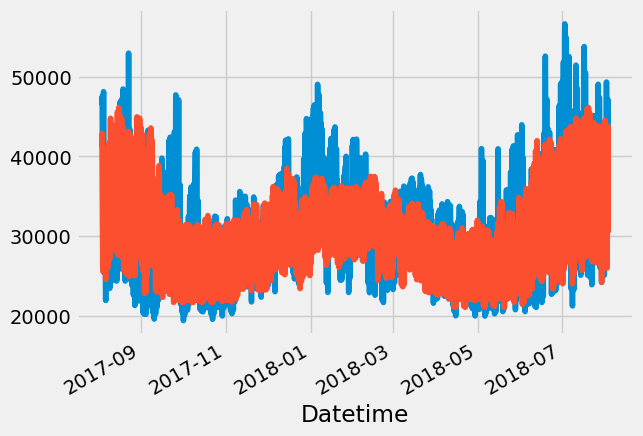

In [ ]:
test['prediction'] = y_pred
test.PJME_MW.plot()
test.prediction.plot()

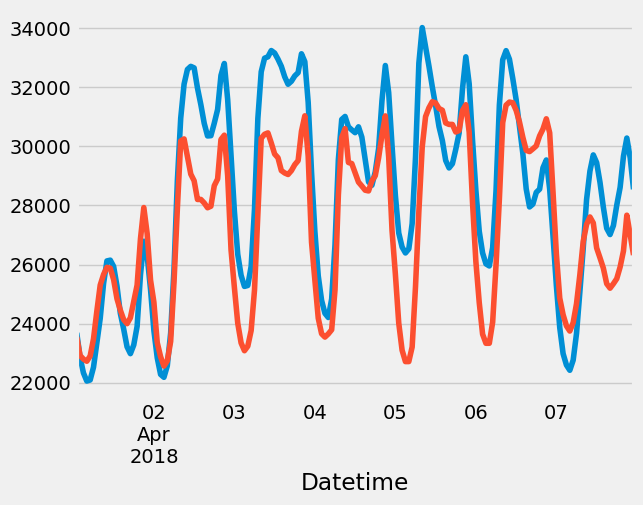

In [ ]:
test[(test.index > '04-01-2018') & (test.index < '04-08-2018')].PJME_MW.plot()
test[(test.index > '04-01-2018') & (test.index < '04-08-2018')].prediction.plot()
plt.show()